In [1]:
import pickle

with open("../data/X.pkl", "rb") as f:
    X = pickle.load(f)

with open("../data/y.pkl", "rb") as f:
    y = pickle.load(f)

print("loaded X shape", X.shape)
print("loaded y shape", y.shape)

loaded X shape (5169, 1024)
loaded y shape (5169,)


In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

# Parameter grid to search
param_grid = {
    'max_iter': [100, 200, 300],           # Boosting iterations (trees)
    'learning_rate': [0.05, 0.1, 0.2],     # Smaller = slower but more stable learning
    'max_leaf_nodes': [31, 63, 127]        # Controls tree complexity (more = deeper)
}
grid = GridSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',      # Optimise for R²
    cv=5,
    n_jobs=-1,         # Use all CPU cores for speed
    verbose=1          # Show progress
)

grid.fit(X, y)
print("best r2 score:", round(grid.best_score_, 3))
print("best parameters:", grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
best r2 score: 0.22
best parameters: {'learning_rate': 0.05, 'max_iter': 200, 'max_leaf_nodes': 31}


In [7]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import numpy as np

best_model = grid.best_estimator_

r2_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("cross-validated r2:", round(np.mean(r2_scores), 3))

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
rmse_scores = cross_val_score(best_model, X, y, cv=5, scoring=rmse_scorer)
print("cross-validated rmse:", round(-np.mean(rmse_scores), 3))

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mae_scores = cross_val_score(best_model, X, y, cv=5, scoring=mae_scorer)
print("cross-validated mae:", round(-np.mean(mae_scores), 3))

cross-validated r2: 0.22
cross-validated rmse: 1.02
cross-validated mae: 0.81


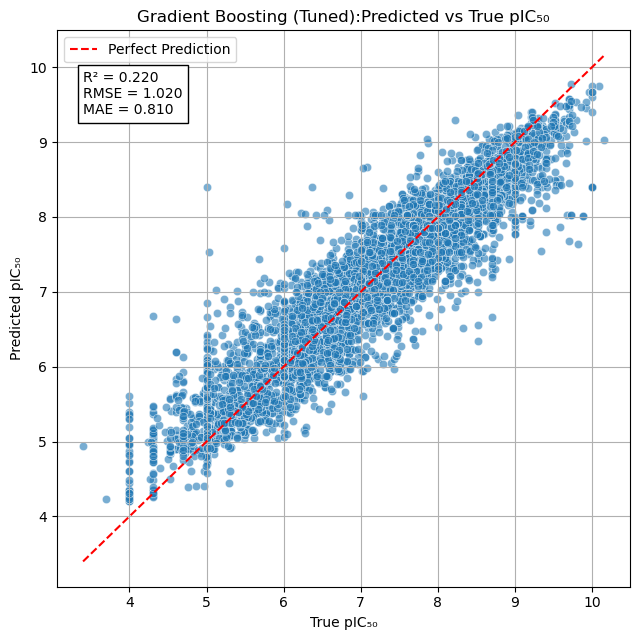

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import os

best_model.fit(X, y)
y_pred = best_model.predict(X)

r2 = np.mean(r2_scores)
rmse = -np.mean(rmse_scores)
mae = -np.mean(mae_scores)

os.makedirs("../plots", exist_ok=True)

plt.figure(figsize=(6.5, 6.5))
sns.scatterplot(x=y, y=y_pred, alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], '--', color='red', label='Perfect Prediction')

plt.xlabel("True pIC₅₀")
plt.ylabel("Predicted pIC₅₀")
plt.title("Gradient Boosting (Tuned):Predicted vs True pIC₅₀")

plt.text(min(y), max(y) - 0.2,
         f"R² = {r2:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}",
         fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))

plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("../plots/pred_vs_true_gradient_boosting_tuned.png", dpi=300)
plt.show()

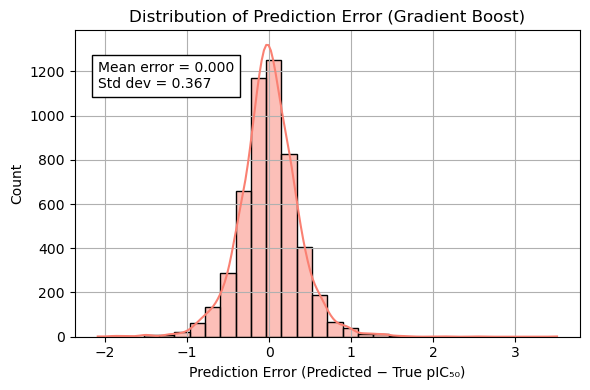

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

model.fit(X, y)
y_pred = model.predict(X)

error = y_pred - y

mean_err = np.mean(error)
std_err = np.std(error)

os.makedirs("../plots", exist_ok=True)

plt.figure(figsize=(6,4))
sns.histplot(error, bins=30, kde=True, color='salmon')
plt.xlabel("Prediction Error (Predicted − True pIC₅₀)")
plt.title("Distribution of Prediction Error (Gradient Boost)")
plt.grid(True)
plt.tight_layout()

plt.text(x=min(error), y=plt.ylim()[1]*0.9, 
         s=f"Mean error = {mean_err:.3f}\nStd dev = {std_err:.3f}",
         bbox=dict(facecolor='white', edgecolor='black'),
         fontsize=10, verticalalignment='top')

plt.savefig("../plots/GB:prediction_error_distribution.png", dpi=300)
plt.show()